# S18 - Part B - VAE with MNIST

#### Imports

In [1]:
import torch
from CustomVAE import VAE
from MNISTDataModule import MNISTDataModuleCustom

C:\Users\SToleti\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\SToleti\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")
C:\Users\SToleti\AppData\Local\Programs\Python\Python311\Lib\site-packages\pl_bolts\__init__.py:11: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
C:\Users\SToleti\AppData\Local\Programs\Python\Python311\Lib\site-packages\pl_bolts\__init__.py:11: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
C:\Users\SToleti\AppData\Local\Programs\Python\Python311\Lib\site-pac

#### Load Datamodule with dataset

In [2]:
datamodule = MNISTDataModuleCustom()

#### Train Data

In [3]:
import pytorch_lightning as pl

pl.seed_everything(1234)
model_vae = VAE()
trainer = pl.Trainer(gpus=1, max_epochs=30)
trainer.fit(model_vae, datamodule)

Global seed set to 1234
D:\SRT_Courses\MachineLearning\TSAI\Session18\Part2\CustomVAE.py:18: UnderReviewWarning: The feature resnet18_encoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  self.encoder = resnet18_encoder(False, False)
C:\Users\SToleti\AppData\Local\Programs\Python\Python311\Lib\site-packages\pl_bolts\models\autoencoders\components.py:334: UnderReviewWarning: The feature ResNetEncoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  return ResNetEncoder(EncoderBlock, [2, 2, 2, 2], first_conv, maxpool1)
C:

Epoch 2:  59%|██████████████████████████▉                   | 549/938 [02:14<01:35,  4.07it/s, loss=2.27e+03, v_num=14]

C:\Users\SToleti\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


#### Plot Data

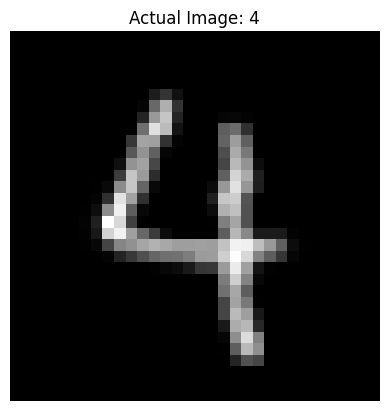

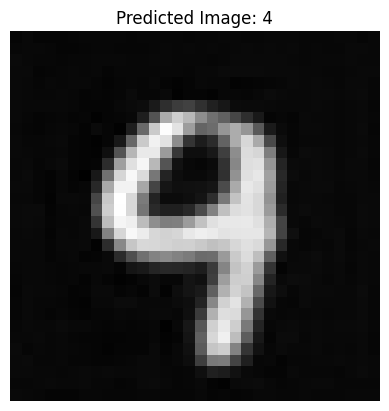

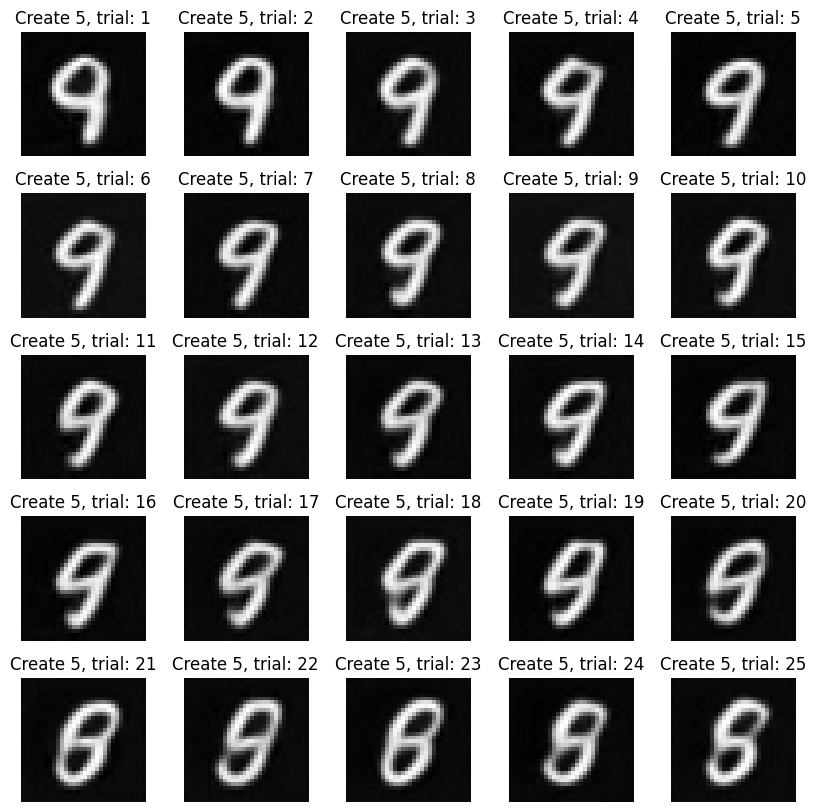

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import random

test_dl = datamodule.test_dataloader()
for batch in test_dl:
    images, label_ohe, label_ohe_random= batch
    break  # Break to get the first batch (a batch of images and labels)

# Select one image and its corresponding label
index = random.randint(0, 63)
image = images[index]
label_ohe_valid= label_ohe[index]
label_ohe_invalid = label_ohe_random[index]

label_valid = np.argmax(label_ohe_valid)
label_invalid = np.argmax(label_ohe_invalid)


# Plot the itest image
plt.imshow(image[0], cmap='gray')
plt.axis('off')
plt.title(f"Actual Image: {label_valid}")
plt.show()
image = image.unsqueeze(0)

with torch.no_grad():
    
    # Now pass this image through VAE encoder and plot the decoder output
    encoded_image = model_vae.encoder(image.to('cuda'))
    combined_features = torch.cat((encoded_image, label_ohe_valid.unsqueeze(0).to('cuda')), dim=1) #get OHE for label features
    mu, log_var = model_vae.fc_mu(combined_features), model_vae.fc_var(combined_features)

    # sample z from q
    std = torch.exp(log_var / 2)
    q = torch.distributions.Normal(mu, std)
    z = q.rsample()

    # decoded 
    decoded_image = model_vae.decoder(z).to('cpu').detach().numpy()

# Plot the generated image with actual label
plt.imshow(decoded_image[0,0], cmap='gray')
plt.axis('off')
plt.title(f"Predicted Image: {label_valid}")
plt.show()

decoded_images = []
decoded_images_plot = []
with torch.no_grad():
    
    for i in range(25):   
        if len(decoded_images) == 0:
            image = image
        else:
            image = decoded_images[-1]
        # Now pass this image through VAE encoder and plot the decoder output
        encoded_image = model_vae.encoder(image.to('cuda'))
        combined_features = torch.cat((encoded_image, label_ohe_invalid.unsqueeze(0).to('cuda')), dim=1) #get OHE for label features
        mu, log_var = model_vae.fc_mu(combined_features), model_vae.fc_var(combined_features)

        # sample z from q
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        # decoded 
        decoded_image = model_vae.decoder(z)
        decoded_images.append(decoded_image)
        decoded_image = decoded_image.to('cpu').detach().numpy()
        decoded_images_plot.append(decoded_image[0, 0])

# Plot the 25 images

# Create a 5x5 grid of subplots
fig, axes = plt.subplots(5, 5, figsize=(10, 10))

# Flatten the axes array so that we can iterate over it easily
axes = axes.flatten()

# Iterate through the images and plot them in the subplots
for i, ax in enumerate(axes):
    ax.imshow(decoded_images_plot[i], cmap='gray')  # Replace 'gray' with a colormap of your choice
    ax.set_title(f"Create {label_invalid}, trial: {i+1}")
    ax.axis('off')  # Turn off axis labels and ticks

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# Display the plot
plt.show()

       
